Shreyaj Padigala: 2nd ForeQast Implementation

Author: Shreyaj Padigala

Project: Research implementation of HM-RNN for temporal hierarchy learning

Reference: Chung et al. - Hierarchical Multiscale Recurrent Neural Networks

This notebook implements a 3-layer HM-RNN from scratch to predict Ethereum prices.
The model learns hierarchical temporal patterns through explicit COPY, UPDATE, and FLUSH operations.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


In [40]:
# Load dataset
df = pd.read_csv('ETH-USD.csv', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (1598, 7)
Date range: 2017-11-09 00:00:00 to 2022-03-25 00:00:00

First few rows:
        Date        Open        High         Low       Close   Adj Close  \
0 2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
1 2017-11-10  320.670990  324.717987  294.541992  299.252991  299.252991   
2 2017-11-11  298.585999  319.453003  298.191986  314.681000  314.681000   
3 2017-11-12  314.690002  319.153015  298.513000  307.907990  307.907990   
4 2017-11-13  307.024994  328.415009  307.024994  316.716003  316.716003   

       Volume  
0   893249984  
1   885985984  
2   842300992  
3  1613479936  
4  1041889984  

Missing values: 0


In [50]:
# Extract Close prices
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()

# Train/Test split by year
# Data range: 2017-2023
# Train: 2017-2022, Test: 2023
train_df = df[df['Date'].dt.year <= 2021].copy()
test_df = df[df['Date'].dt.year == 2022].copy()

print(f"Train samples: {len(train_df)} (from {train_df['Date'].min()} to {train_df['Date'].max()})")
print(f"Test samples: {len(test_df)} (from {test_df['Date'].min()} to {test_df['Date'].max()})")

# Normalize using training set statistics
# We'll use Close price directly (normalized)
train_close = train_df['Close'].values
test_close = test_df['Close'].values

close_mean = train_close.mean()
close_std = train_close.std()

train_close_norm = (train_close - close_mean) / close_std
test_close_norm = (test_close - close_mean) / close_std

print(f"\nPrice normalization: mean={close_mean:.2f}, std={close_std:.2f}")

Train samples: 1512 (from 2017-11-11 00:00:00 to 2021-12-31 00:00:00)
Test samples: 84 (from 2022-01-01 00:00:00 to 2022-03-25 00:00:00)

Price normalization: mean=923.99, std=1177.85


In [51]:
def create_sequences(data, seq_length=30):
    """
    Create sequences for time series prediction.

    Args:
        data: 1D array of normalized prices
        seq_length: Number of time steps in each sequence

    Returns:
        X: Input sequences (n_samples, seq_length, 1)
        y: Target values (n_samples,) - next day price
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])  # Next day prediction

    X = np.array(X).reshape(-1, seq_length, 1)
    y = np.array(y)
    return X, y

# Create sequences
SEQ_LENGTH = 30
X_train, y_train = create_sequences(train_close_norm, SEQ_LENGTH)
X_test, y_test = create_sequences(test_close_norm, SEQ_LENGTH)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1482, 30, 1)
y_train shape: (1482,)
X_test shape: (54, 30, 1)
y_test shape: (54,)


In [52]:
class HardSigmoid(keras.layers.Layer):
    """
    Hard sigmoid with straight-through estimator.
    Forward: hard threshold at 0.5
    Backward: sigmoid gradients
    """
    def call(self, x):
        # Sigmoid for gradient
        soft = tf.nn.sigmoid(x)
        # Hard threshold for forward pass
        hard = tf.cast(soft > 0.5, tf.float32)
        # Straight-through: use hard in forward, soft gradients in backward
        return hard + tf.stop_gradient(hard - soft)


class HMRNNCell(keras.layers.Layer):
    """
    Single HM-RNN cell implementing COPY, UPDATE, and FLUSH operations.

    Args:
        units: Hidden state dimension
        layer_idx: Layer index (0, 1, 2 for 3-layer model)
    """
    def __init__(self, units, layer_idx, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.layer_idx = layer_idx
        self.state_size = [units, units, 1]  # [h, c, z_prev]

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # LSTM-style gates for UPDATE and FLUSH
        self.W_i = self.add_weight(shape=(input_dim, self.units), name='W_i')
        self.U_i = self.add_weight(shape=(self.units, self.units), name='U_i')
        self.b_i = self.add_weight(shape=(self.units,), name='b_i',
                                    initializer='zeros')

        self.W_f = self.add_weight(shape=(input_dim, self.units), name='W_f')
        self.U_f = self.add_weight(shape=(self.units, self.units), name='U_f')
        self.b_f = self.add_weight(shape=(self.units,), name='b_f',
                                    initializer='ones')  # Forget bias = 1

        self.W_c = self.add_weight(shape=(input_dim, self.units), name='W_c')
        self.U_c = self.add_weight(shape=(self.units, self.units), name='U_c')
        self.b_c = self.add_weight(shape=(self.units,), name='b_c',
                                    initializer='zeros')

        self.W_o = self.add_weight(shape=(input_dim, self.units), name='W_o')
        self.U_o = self.add_weight(shape=(self.units, self.units), name='U_o')
        self.b_o = self.add_weight(shape=(self.units,), name='b_o',
                                    initializer='zeros')

        # Boundary detector
        self.W_z = self.add_weight(shape=(self.units, 1), name='W_z')
        self.b_z = self.add_weight(shape=(1,), name='b_z',
                                    initializer='zeros')

        self.hard_sigmoid = HardSigmoid()

    def call(self, inputs, states):
        """
        Execute one time step with COPY, UPDATE, or FLUSH.

        Args:
            inputs: (batch, input_dim) - output from layer below or raw input
            states: [h_prev, c_prev, z_prev_layer]
                h_prev: previous hidden state
                c_prev: previous cell state
                z_prev_layer: previous boundary signal from this layer

        Returns:
            output: current hidden state
            [h_new, c_new, z_current]: new states
        """
        h_prev, c_prev, z_prev_layer = states

        # Determine which operation to perform
        # For layer 0, assume input always triggers update (z_below = 1)
        # For layers > 0, z_below comes from the input

        # OPERATION 1: FLUSH - reset when previous step had boundary
        # Condition: z_prev_layer == 1
        flush_mask = z_prev_layer  # (batch, 1)

        # OPERATION 2: UPDATE - integrate new info
        # Perform LSTM update
        i = tf.nn.sigmoid(tf.matmul(inputs, self.W_i) +
                          tf.matmul(h_prev, self.U_i) + self.b_i)
        f = tf.nn.sigmoid(tf.matmul(inputs, self.W_f) +
                          tf.matmul(h_prev, self.U_f) + self.b_f)
        c_tilde = tf.nn.tanh(tf.matmul(inputs, self.W_c) +
                             tf.matmul(h_prev, self.U_c) + self.b_c)
        o = tf.nn.sigmoid(tf.matmul(inputs, self.W_o) +
                          tf.matmul(h_prev, self.U_o) + self.b_o)

        c_updated = f * c_prev + i * c_tilde
        h_updated = o * tf.nn.tanh(c_updated)

        # Apply FLUSH: if z_prev_layer == 1, reset to initial state
        # When flushing, we process the input with zero initial state
        c_flushed = i * c_tilde  # Reset cell state
        h_flushed = o * tf.nn.tanh(c_flushed)

        # Choose between UPDATE and FLUSH
        c_new = flush_mask * c_flushed + (1 - flush_mask) * c_updated
        h_new = flush_mask * h_flushed + (1 - flush_mask) * h_updated

        # NOTE: COPY is implicitly handled - if no update signal arrives,
        # the layer above won't call this cell, maintaining previous state

        # Compute boundary detector
        z_logit = tf.matmul(h_new, self.W_z) + self.b_z
        z_current = self.hard_sigmoid(z_logit)

        return h_new, [h_new, c_new, z_current]


class HMRNNLayer(keras.layers.Layer):
    """
    Wraps HMRNNCell for sequence processing with explicit operation tracking.
    """
    def __init__(self, units, layer_idx, return_sequences=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.layer_idx = layer_idx
        self.return_sequences = return_sequences
        self.cell = HMRNNCell(units, layer_idx)

    def call(self, inputs, training=None):
        """
        Process sequence through HM-RNN layer.

        Args:
            inputs: (batch, time, features)

        Returns:
            outputs: (batch, time, units) if return_sequences else (batch, units)
            boundaries: (batch, time, 1) - boundary activations for visualization
        """
        batch_size = tf.shape(inputs)[0]

        # Initialize states
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))
        z_prev = tf.zeros((batch_size, 1))

        # Unstack the sequence dimension to iterate in graph mode
        # inputs shape: (batch, time, features) -> list of (batch, features)
        input_steps = tf.unstack(inputs, axis=1)

        outputs = []
        boundaries = []

        # Process each time step
        for x_t in input_steps:
            h, [h, c, z] = self.cell(x_t, [h, c, z_prev])
            outputs.append(h)
            boundaries.append(z)
            z_prev = z

        # Stack outputs back to tensor
        outputs = tf.stack(outputs, axis=1)  # (batch, time, units)
        boundaries = tf.stack(boundaries, axis=1)  # (batch, time, 1)

        if self.return_sequences:
            return outputs, boundaries
        else:
            return outputs[:, -1, :], boundaries


print("HM-RNN components defined successfully!")

HM-RNN components defined successfully!


In [53]:
class HMRNN(keras.Model):
    """
    3-layer Hierarchical Multiscale RNN for price prediction.
    """
    def __init__(self, hidden_sizes=[64, 32, 16], **kwargs):
        super().__init__(**kwargs)

        # Three hierarchical layers
        self.layer1 = HMRNNLayer(hidden_sizes[0], layer_idx=0,
                                  return_sequences=True, name='hmrnn_layer1')
        self.layer2 = HMRNNLayer(hidden_sizes[1], layer_idx=1,
                                  return_sequences=True, name='hmrnn_layer2')
        self.layer3 = HMRNNLayer(hidden_sizes[2], layer_idx=2,
                                  return_sequences=False, name='hmrnn_layer3')

        # Output layer for price prediction
        self.output_layer = layers.Dense(1, name='price_prediction')

        # Store boundaries for visualization (will be populated during forward pass)
        self.boundaries = None

    def call(self, inputs, training=None, return_boundaries=False):
        """
        Forward pass through hierarchical layers.

        Args:
            inputs: (batch, seq_len, 1)
            training: whether in training mode
            return_boundaries: if True, return both predictions and boundaries

        Returns:
            prediction: (batch, 1) or tuple (prediction, boundaries) if return_boundaries=True
        """
        # Layer 1: Fast timescale
        h1, z1 = self.layer1(inputs, training=training)

        # Layer 2: Medium timescale
        h2, z2 = self.layer2(h1, training=training)

        # Layer 3: Slow timescale
        h3, z3 = self.layer3(h2, training=training)

        # Prediction head
        prediction = self.output_layer(h3)

        # Store boundaries for later access
        self.boundaries = [z1, z2, z3]

        if return_boundaries:
            return prediction, [z1, z2, z3]
        else:
            return prediction


# Instantiate model
model = HMRNN(hidden_sizes=[64, 32, 16])

# Build model
model.build(input_shape=(None, SEQ_LENGTH, 1))
model.summary()

Model: "hmrnn_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hmrnn_layer1 (HMRNNLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hmrnn_layer2 (HMRNNLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hmrnn_layer3 (HMRNNLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ price_prediction (Dense)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
BOUNDARY_LAMBDA = 0.01  # Sparsity regularization
CLIP_NORM = 1.0

# Optimizer with gradient clipping
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=CLIP_NORM)

# Loss function
mse_loss = keras.losses.MeanSquaredError()


@tf.function
def train_step(x_batch, y_batch):
    """
    Single training step with boundary regularization.
    """
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model(x_batch, training=True)

        # Prediction loss
        loss = mse_loss(y_batch, predictions)

        # Boundary sparsity regularization
        # Encourage sparse boundary activations (higher layers should fire less)
        boundary_reg = 0.0
        for i, z in enumerate(model.boundaries):
            # Weight increases with layer depth
            boundary_reg += (i + 1) * tf.reduce_mean(z)

        total_loss = loss + BOUNDARY_LAMBDA * boundary_reg

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, boundary_reg


@tf.function
def test_step(x_batch, y_batch):
    """
    Validation step.
    """
    predictions = model(x_batch, training=False)
    loss = mse_loss(y_batch, predictions)
    return loss


print("Training functions defined.")

Training functions defined.


In [55]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Training history
history = {
    'train_loss': [],
    'test_loss': [],
    'boundary_reg': []
}

print("Starting training...\n")

for epoch in range(EPOCHS):
    # Training
    train_losses = []
    boundary_regs = []

    for x_batch, y_batch in train_dataset:
        loss, b_reg = train_step(x_batch, y_batch)
        train_losses.append(loss.numpy())
        boundary_regs.append(b_reg.numpy())

    # Validation
    test_losses = []
    for x_batch, y_batch in test_dataset:
        loss = test_step(x_batch, y_batch)
        test_losses.append(loss.numpy())

    # Record metrics
    epoch_train_loss = np.mean(train_losses)
    epoch_test_loss = np.mean(test_losses)
    epoch_boundary_reg = np.mean(boundary_regs)

    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(epoch_test_loss)
    history['boundary_reg'].append(epoch_boundary_reg)

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"  Train Loss: {epoch_train_loss:.6f}")
        print(f"  Test Loss:  {epoch_test_loss:.6f}")
        print(f"  Boundary Regularization: {epoch_boundary_reg:.6f}\n")

print("Training complete!")

Starting training...

Epoch 5/10
  Train Loss: 0.112049
  Test Loss:  0.662482
  Boundary Regularization: 3.460488

Epoch 10/10
  Train Loss: 0.073398
  Test Loss:  0.130710
  Boundary Regularization: 2.493854

Training complete!


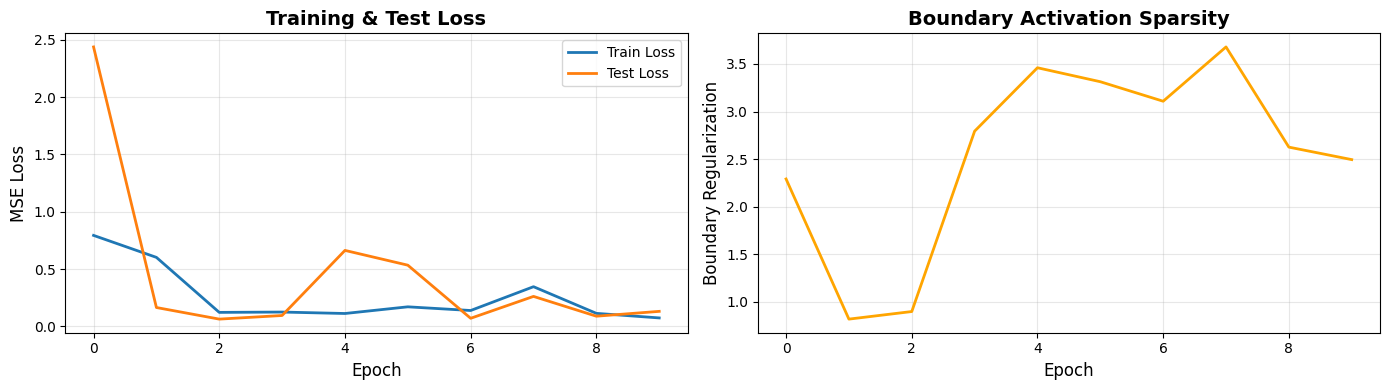

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['test_loss'], label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Training & Test Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boundary regularization
axes[1].plot(history['boundary_reg'], color='orange', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Boundary Regularization', fontsize=12)
axes[1].set_title('Boundary Activation Sparsity', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [57]:
# Generate predictions on test set
# Use manual batching to avoid Keras predict() issues
predictions = []
batch_size = 32

for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i+batch_size]
    pred = model(batch, training=False)
    predictions.append(pred.numpy())

y_pred_norm = np.concatenate(predictions, axis=0)

# Denormalize predictions and targets
y_pred = y_pred_norm.flatten() * close_std + close_mean
y_true = y_test * close_std + close_mean

# Compute metrics
mse = np.mean((y_pred - y_true) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - y_true))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print("="*50)

TEST SET PERFORMANCE
MSE:  178638.46
RMSE: 422.66
MAE:  378.89
MAPE: 13.93%


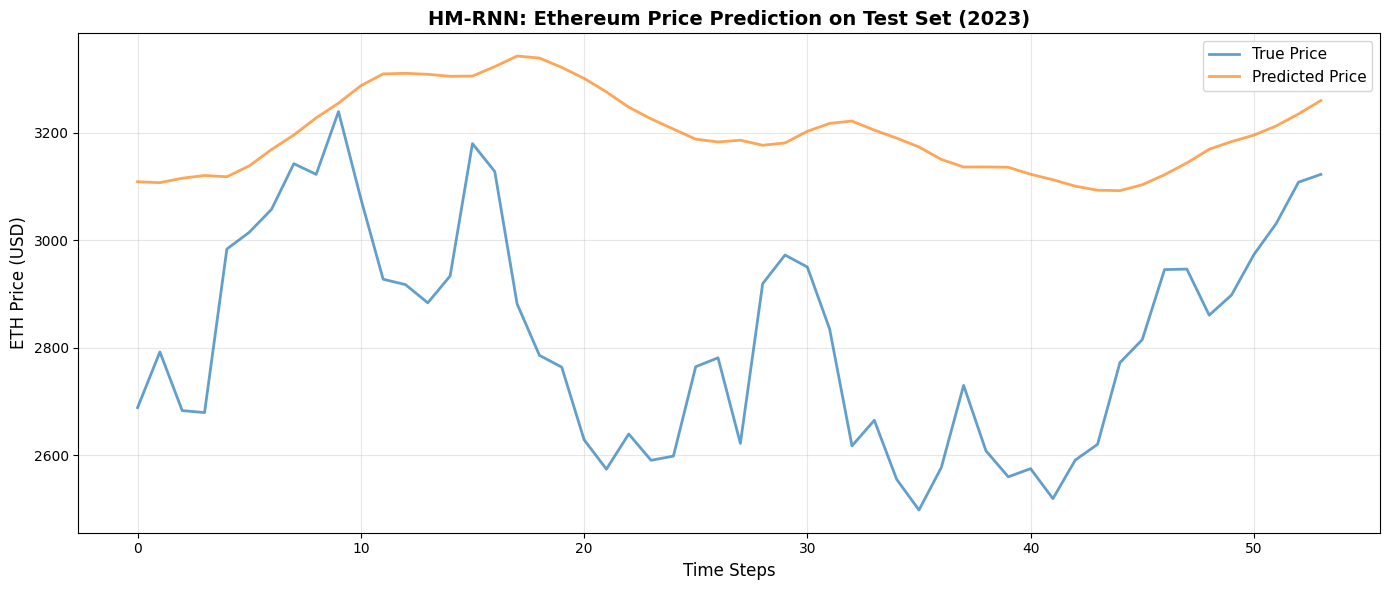

In [58]:
plt.figure(figsize=(14, 6))

# Plot true vs predicted prices
plt.plot(y_true, label='True Price', linewidth=2, alpha=0.7)
plt.plot(y_pred, label='Predicted Price', linewidth=2, alpha=0.7)

plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('ETH Price (USD)', fontsize=12)
plt.title('HM-RNN: Ethereum Price Prediction on Test Set (2023)',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

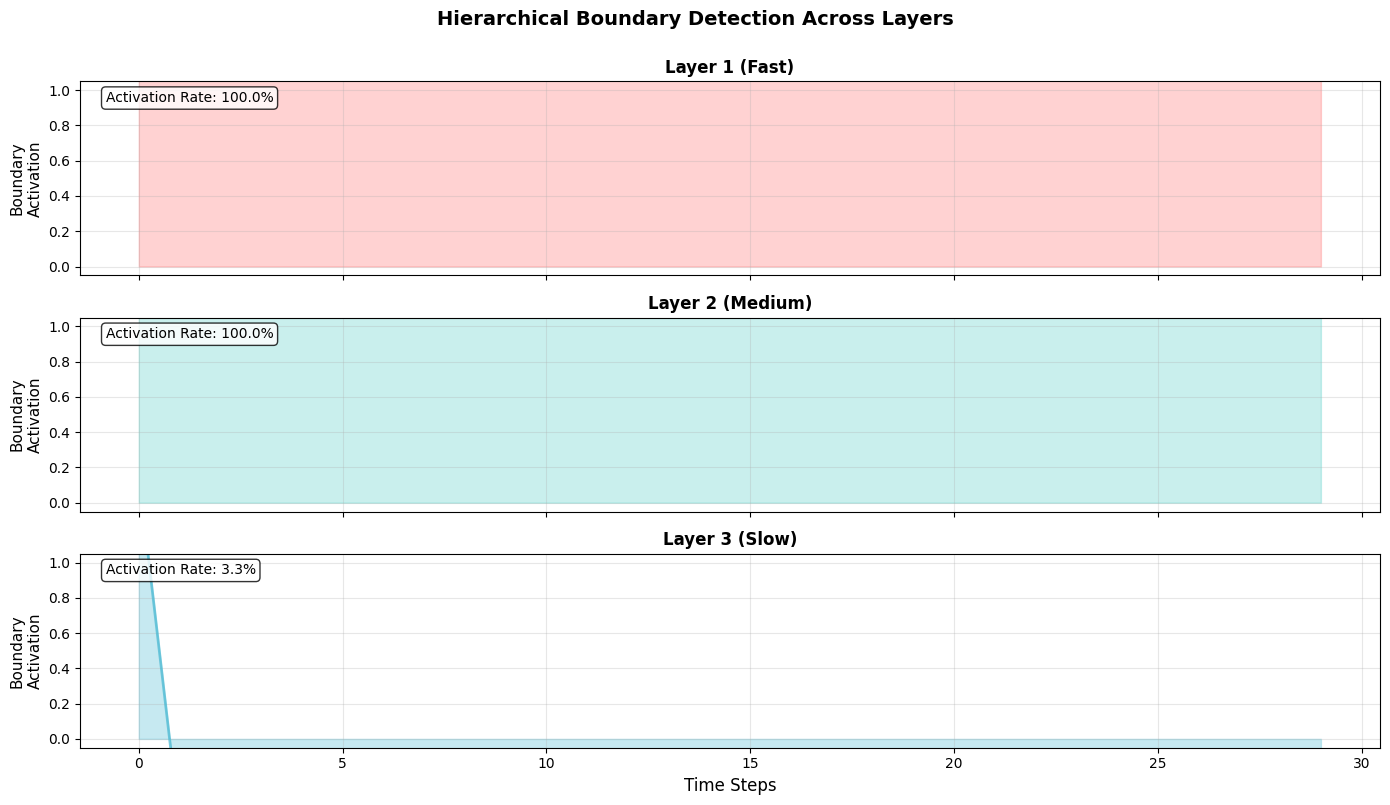


Boundary Activation Statistics:
Layer 1 (Fast)      : 100.00% activation rate
Layer 2 (Medium)    : 100.00% activation rate
Layer 3 (Slow)      :  3.33% activation rate


In [59]:
# Get boundary activations for a sample batch
sample_size = min(200, len(X_test))
X_sample = X_test[:sample_size]

# Forward pass to get boundaries
# Use the model's call method directly to access boundaries
_ = model(X_sample, training=False)
z1, z2, z3 = model.boundaries

# Convert to numpy and take mean over batch
z1_avg = tf.reduce_mean(z1, axis=0).numpy().squeeze()
z2_avg = tf.reduce_mean(z2, axis=0).numpy().squeeze()
z3_avg = tf.reduce_mean(z3, axis=0).numpy().squeeze()

# Plot boundary activations
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

layer_names = ['Layer 1 (Fast)', 'Layer 2 (Medium)', 'Layer 3 (Slow)']
boundaries = [z1_avg, z2_avg, z3_avg]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (ax, z, name, color) in enumerate(zip(axes, boundaries, layer_names, colors)):
    ax.plot(z, color=color, linewidth=2, alpha=0.7)
    ax.fill_between(range(len(z)), z, alpha=0.3, color=color)
    ax.set_ylabel('Boundary\nActivation', fontsize=11)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_ylim([-0.05, 1.05])

    # Add activation rate
    activation_rate = np.mean(z > 0.5) * 100
    ax.text(0.02, 0.95, f'Activation Rate: {activation_rate:.1f}%',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[-1].set_xlabel('Time Steps', fontsize=12)
fig.suptitle('Hierarchical Boundary Detection Across Layers',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print statistics
print("\nBoundary Activation Statistics:")
print("="*50)
for i, (z, name) in enumerate(zip(boundaries, layer_names), 1):
    activation_rate = np.mean(z > 0.5) * 100
    print(f"{name:20s}: {activation_rate:5.2f}% activation rate")
print("="*50)